In [1]:
# Base & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

# Oversampling
from imblearn.combine import  SMOTETomek

# Modeling
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

# BayesianOptimizer
from bayes_opt import BayesianOptimization

# Saving Model
import joblib

In [2]:
train = pd.read_csv('data/part/one-hot_encoding/iterative/oversampling/part_one_iter_tomek_train.csv')
label = pd.read_csv('data/part/one-hot_encoding/iterative/oversampling/label/part_one_iter_tomek_label.csv')
test = pd.read_csv('data/one_hot_test.csv')
test_id = pd.read_csv('data/sample_submission.csv')['ID']

train_x = np.array(train)
train_y = np.array(label)
test_x = np.array(test)
train_s = np.array(train.loc[:,test.columns])

In [3]:
# Catboost
cb_pbounds = { 'n_estimators' : (200, 400),
               'learning_rate' : (0.01, 0.5),
               'max_depth' : (4, 10),
               'random_strength' : (0.1, 0.9),
               'l2_leaf_reg' : (1, 5) }

# XGB
xgb_pbounds = { 'n_estimators' : (50, 400),
                'learning_rate' : (0.001, 0.5),
                'max_depth' : (4, 10),
                'subsample' : (0.7, 1),
                'colsample_bytree' : (0.7, 1),
                'min_child_weight' : (1, 15) }

# LGBM
lgbm_pbounds = { 'n_estimators' : (100, 400),
                 'learning_rate' : (0.01, 0.5),
                 'max_depth' : (4, 10),
                 'subsample' : (0.7, 1),
                 'colsample_bytree' : (0.7, 0.95),
                 'num_leaves': (2,10),
                 'min_child_weight' : (1, 15) }

# ExtraTree
et_pbounds = { 'n_estimators' : (50, 300), 'max_depth' : (4, 10),
               'min_samples_split' : (2, 15), 'min_samples_leaf' : (2, 15) }

In [4]:
tune_et_clf = joblib.load('model_save/tuning/task1_et_clf.pkl')

tune_et_clf_pred_proba = np.array([i[1] for i in tune_et_clf.predict_proba(train_x)])
tune_et_clf_pred_proba

array([0.30727496, 0.31466006, 0.48001105, ..., 0.61093723, 0.5792827 ,
       0.63243439])

In [5]:
def cb_reg_opt(n_estimators, learning_rate, max_depth, random_strength, l2_leaf_reg):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'random_strength' : random_strength,
               'l2_leaf_reg' : l2_leaf_reg }
    
    cb = CatBoostRegressor(**params)
    skf = KFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(cb, train_s, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def xgb_reg_opt(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, min_child_weight):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'min_child_weight' : min_child_weight, 'n_jobs' : -1 }
    
    xgb = XGBRegressor(**params)
    skf = KFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(xgb, train_s, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def lgbm_reg_opt(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'num_leaves' : int(round(num_leaves)),
               'min_child_weight' : min_child_weight,'n_jobs' : -1 }
    
    lgbm = LGBMRegressor(**params)
    skf = KFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(lgbm, train_s, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def et_reg_opt(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'max_depth' : int(round(max_depth)),
               'min_samples_split' : int(round(min_samples_split)),
               'min_samples_leaf' : int(round(min_samples_leaf)), 'n_jobs' : -1 }
    
    et = ExtraTreesRegressor(**params)
    skf = KFold(n_splits = 4, shuffle = True, random_state = 17)
    score = cross_val_score(et, train_s, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

In [6]:
#BO_cb_reg = BayesianOptimization(f = cb_reg_opt, pbounds = cb_pbounds, random_state=17)
BO_xgb_reg = BayesianOptimization(f = xgb_reg_opt, pbounds = xgb_pbounds, random_state=17)
BO_lgbm_reg = BayesianOptimization(f = lgbm_reg_opt, pbounds = lgbm_pbounds, random_state=17)
BO_et_reg = BayesianOptimization(f = et_reg_opt, pbounds = et_pbounds, random_state=17)

In [ ]:
# Catboost Maximize
#BO_cb_reg.maximize(init_points=50, n_iter=50)

In [9]:
# XGB Maximize
BO_xgb_reg.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -0.003656 | 0.7884    | 0.2658    | 5.149     | 1.951     | 325.4     | 0.8969    |
| 2         | -0.003811 | 0.8913    | 0.2882    | 4.234     | 6.009     | 381.0     | 0.718     |
| 3         | -0.003939 | 0.9592    | 0.4388    | 4.307     | 10.13     | 243.1     | 0.8793    |
| 4         | -0.003632 | 0.8451    | 0.1422    | 5.786     | 8.861     | 188.6     | 0.9366    |
| 5         | -0.003824 | 0.8255    | 0.07281   | 4.905     | 1.773     | 301.3     | 0.7877    |
| 6         | -0.004177 | 0.7596    | 0.4159    | 7.408     | 2.153     | 240.7     | 0.7477    |
| 7         | -0.00354  | 0.903     | 0.06012   | 6.67      | 13.43     | 329.0     | 0.7204    |
| 8         | -0.003865 | 0.9882    | 0.3299    | 8.313     | 11.41     | 360.7     | 0.7402    |
| 9         | -0.004

| 51        | -0.003692 | 0.9321    | 0.3314    | 7.489     | 2.209     | 236.9     | 0.9461    |
| 52        | -0.003818 | 0.7125    | 0.1343    | 4.8       | 6.144     | 192.6     | 0.952     |
| 53        | -0.003954 | 0.8064    | 0.3959    | 6.896     | 14.83     | 157.9     | 0.7548    |
| 54        | -0.003638 | 0.9514    | 0.171     | 9.557     | 14.41     | 60.49     | 0.7924    |
| 55        | -0.003617 | 0.9583    | 0.04195   | 8.049     | 4.931     | 253.9     | 0.7596    |
| 56        | -0.005283 | 0.9709    | 0.06442   | 6.515     | 14.54     | 57.45     | 0.7783    |
| 57        | -0.003585 | 0.8643    | 0.232     | 6.923     | 3.327     | 132.4     | 0.9212    |
| 58        | -0.003854 | 0.7393    | 0.3931    | 4.223     | 6.85      | 393.0     | 0.978     |
| 59        | -0.003673 | 0.7165    | 0.3101    | 8.571     | 10.0      | 373.3     | 0.9357    |
| 60        | -0.003732 | 0.883     | 0.2898    | 6.815     | 8.601     | 392.2     | 0.7718    |
| 61        | -0.003

In [7]:
# LGBM Maximize
BO_lgbm_reg.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.003906 | 0.7737    | 0.27      | 5.149     | 1.951     | 336.1     | 7.251     | 0.8913    |
| 2         | -0.007188 | 0.8439    | 0.02914   | 6.147     | 14.24     | 118.0     | 8.912     | 0.9632    |
| 3         | -0.004337 | 0.7128    | 0.3297    | 7.311     | 9.365     | 245.1     | 4.264     | 0.7893    |
| 4         | -0.00512  | 0.8404    | 0.2041    | 8.732     | 6.859     | 143.2     | 3.207     | 0.7166    |
| 5         | -0.004879 | 0.8795    | 0.1532    | 5.193     | 12.64     | 270.4     | 2.659     | 0.8635    |
| 6         | -0.003804 | 0.7397    | 0.3416    | 4.711     | 7.23      | 366.4     | 8.378     | 0.7204    |
| 7         | -0.004388 | 0.9402    | 0.333     | 8.313     | 11.41     | 366.3     | 3.072     | 0.9331    |
| 8       

| 45        | -0.004854 | 0.9142    | 0.4414    | 5.075     | 4.036     | 110.6     | 3.204     | 0.7346    |
| 46        | -0.004363 | 0.9259    | 0.4903    | 7.059     | 7.25      | 305.4     | 2.992     | 0.9097    |
| 47        | -0.004274 | 0.8098    | 0.3313    | 8.782     | 8.678     | 191.6     | 4.634     | 0.7631    |
| 48        | -0.004474 | 0.8969    | 0.208     | 8.259     | 5.027     | 185.8     | 4.667     | 0.8516    |
| 49        | -0.004295 | 0.9305    | 0.3636    | 5.602     | 1.524     | 232.7     | 4.318     | 0.9316    |
| 50        | -0.005108 | 0.8001    | 0.1013    | 9.33      | 12.33     | 202.6     | 4.302     | 0.886     |
| 51        | -0.0042   | 0.9468    | 0.1198    | 8.458     | 3.426     | 283.2     | 8.484     | 0.8796    |
| 52        | -0.004527 | 0.7204    | 0.06372   | 8.572     | 6.1       | 251.5     | 9.453     | 0.7885    |
| 53        | -0.003808 | 0.7729    | 0.4471    | 6.196     | 4.763     | 387.1     | 7.764     | 0.769     |
| 54      

| 91        | -0.004042 | 0.828     | 0.1228    | 7.788     | 5.467     | 330.2     | 9.378     | 0.8097    |
| 92        | -0.003891 | 0.7522    | 0.226     | 8.229     | 9.471     | 326.2     | 8.426     | 0.9558    |
| 93        | -0.004035 | 0.8612    | 0.1271    | 4.584     | 11.45     | 324.6     | 8.786     | 0.7235    |
| 94        | -0.003985 | 0.8917    | 0.133     | 7.909     | 10.46     | 319.5     | 9.675     | 0.9794    |
| 95        | -0.003924 | 0.7026    | 0.2733    | 4.268     | 13.2      | 318.0     | 6.856     | 0.7057    |
| 96        | -0.004051 | 0.8554    | 0.1687    | 9.732     | 13.98     | 319.2     | 6.582     | 0.7582    |
| 97        | -0.003756 | 0.7937    | 0.3386    | 8.774     | 13.44     | 328.9     | 9.543     | 0.743     |
| 98        | -0.004009 | 0.9142    | 0.4219    | 6.37      | 14.9      | 328.7     | 5.455     | 0.9014    |
| 99        | -0.003962 | 0.9114    | 0.1443    | 8.046     | 13.83     | 333.6     | 9.027     | 0.7753    |
| 100     

In [8]:
# ExtraTrees Maximize
BO_et_reg.maximize(init_points=50, n_iter=50)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.01302  | 5.768     | 8.898     | 4.49      | 66.98     |
| 2         | -0.01019  | 8.722     | 10.53     | 10.29     | 193.9     |
| 3         | -0.01538  | 4.234     | 6.652     | 14.29     | 65.01     |
| 4         | -0.01028  | 9.184     | 13.4      | 2.666     | 213.1     |
| 5         | -0.01205  | 7.311     | 9.768     | 8.286     | 120.7     |
| 6         | -0.013    | 5.786     | 9.3       | 7.149     | 247.2     |
| 7         | -0.01194  | 6.511     | 3.871     | 3.962     | 63.81     |
| 8         | -0.0111   | 8.308     | 5.8       | 4.584     | 257.8     |
| 9         | -0.01206  | 7.408     | 3.07      | 9.085     | 89.74     |
| 10        | -0.01106  | 8.061     | 3.54      | 7.785     | 272.0     |
| 11        | -0.01027  | 8.784     | 2.884     | 14.49     | 214.8     |
| 12        | -0.01113  | 8.313     | 

| 67        | -0.01025  | 9.415     | 9.784     | 3.297     | 208.5     |
| 68        | -0.009539 | 9.847     | 2.795     | 10.24     | 108.2     |
| 69        | -0.009412 | 10.0      | 3.859     | 15.0      | 104.4     |
| 70        | -0.01533  | 4.494     | 3.416     | 13.69     | 106.9     |
| 71        | -0.009461 | 9.546     | 9.413     | 14.5      | 103.8     |
| 72        | -0.009497 | 9.957     | 10.69     | 14.76     | 211.1     |
| 73        | -0.01022  | 9.454     | 5.456     | 11.15     | 209.8     |
| 74        | -0.01208  | 7.3       | 14.74     | 10.76     | 213.0     |
| 75        | -0.009482 | 10.0      | 9.901     | 15.0      | 206.0     |
| 76        | -0.009395 | 10.0      | 4.849     | 10.55     | 102.0     |
| 77        | -0.009359 | 10.0      | 2.0       | 13.7      | 234.9     |
| 78        | -0.009385 | 9.864     | 2.628     | 5.816     | 235.5     |
| 79        | -0.01537  | 4.213     | 2.124     | 10.3      | 236.2     |
| 80        | -0.009479 | 10.0      | 

In [10]:
# Catboost Max Parameters
'''cb_reg_max_params = BO_cb_reg.max['params']
cb_reg_max_params['n_estimators'] = int(round(cb_reg_max_params['n_estimators']))
cb_reg_max_params['max_depth'] = int(round(cb_reg_max_params['max_depth']))'''

# XGB Max Parameters
xgb_reg_max_params = BO_xgb_reg.max['params']
xgb_reg_max_params['n_estimators'] = int(round(xgb_reg_max_params['n_estimators']))
xgb_reg_max_params['max_depth'] = int(round(xgb_reg_max_params['max_depth']))

# LGBM Max Parameters
lgbm_reg_max_params = BO_lgbm_reg.max['params']
lgbm_reg_max_params['n_estimators'] = int(round(lgbm_reg_max_params['n_estimators']))
lgbm_reg_max_params['max_depth'] = int(round(lgbm_reg_max_params['max_depth']))
lgbm_reg_max_params['num_leaves'] = int(round(lgbm_reg_max_params['num_leaves']))

# ExtraTrees Max Parameters
et_reg_max_params = BO_et_reg.max['params']
et_reg_max_params['n_estimators'] = int(round(et_reg_max_params['n_estimators']))
et_reg_max_params['max_depth'] = int(round(et_reg_max_params['max_depth']))
et_reg_max_params['min_samples_split'] = int(round(et_reg_max_params['min_samples_split']))
et_reg_max_params['min_samples_leaf'] = int(round(et_reg_max_params['min_samples_leaf']))

tune_cb_reg = CatBoostRegressor(**cb_reg_max_params)
tune_cb_reg.fit(train_s,train_y)

In [11]:
tune_xgb_reg = XGBRegressor(**xgb_reg_max_params)
tune_xgb_reg.fit(train_s,train_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7791682677670975, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.06874001460156993,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0,
             min_child_weight=8.225025470833163, missing=nan,
             monotone_constraints='()', n_estimators=347, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [12]:
tune_lgbm_reg = LGBMRegressor(**lgbm_reg_max_params)
tune_lgbm_reg.fit(train_s,train_y)

C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(colsample_bytree=0.9339334278512058,
              learning_rate=0.25158858664918043, max_depth=8,
              min_child_weight=3.900381401962542, n_estimators=387,
              num_leaves=10, subsample=0.9488136530060359)

In [13]:
tune_et_reg = ExtraTreesRegressor(**et_reg_max_params)
tune_et_reg.fit(train_s,train_y)

C:\Users\82107\AppData\Local\Temp\ipykernel_2984\1637458044.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tune_et_reg.fit(train_s,train_y)


ExtraTreesRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=15,
                    n_estimators=128)

In [14]:
# Predict target by test_x
#tune_cb_reg_pred = tune_cb_reg.predict(test_x)
tune_xgb_reg_pred = tune_xgb_reg.predict(test_x)
tune_lgbm_reg_pred = tune_lgbm_reg.predict(test_x)
tune_et_reg_pred = tune_et_reg.predict(test_x)

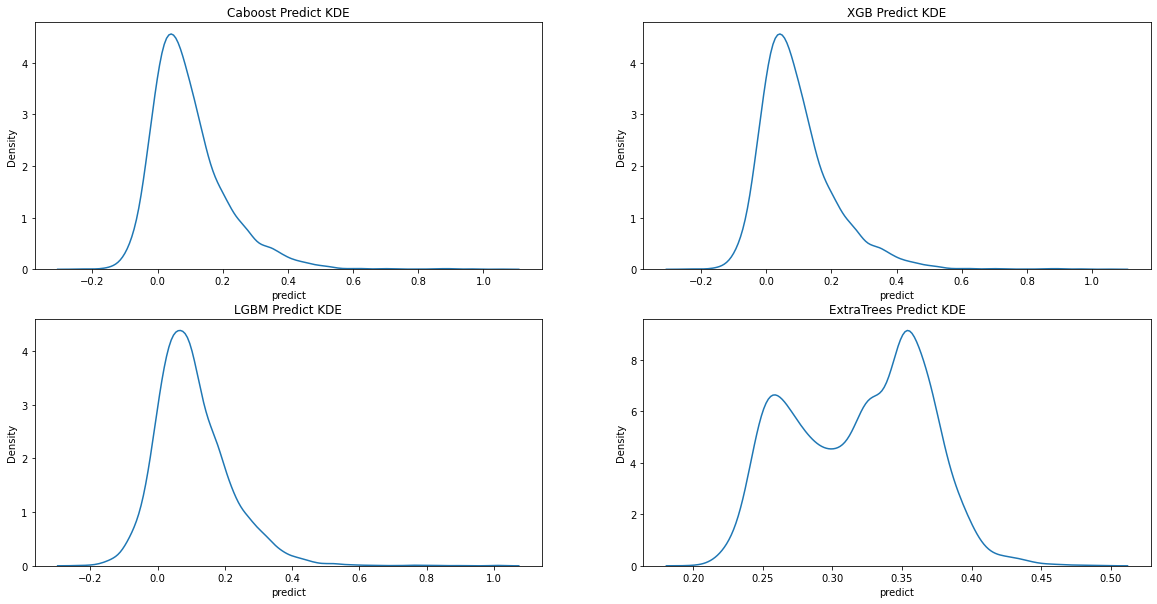

In [15]:
# Visualize target predict
#cb_pred = pd.DataFrame({'predict':tune_cb_reg_pred})
xgb_pred = pd.DataFrame({'predict':tune_xgb_reg_pred})
lgbm_pred = pd.DataFrame({'predict':tune_lgbm_reg_pred})
et_pred = pd.DataFrame({'predict':tune_et_reg_pred})

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.kdeplot(xgb_pred.predict)
plt.title('Caboost Predict KDE')

plt.subplot(2,2,2)
sns.kdeplot(xgb_pred.predict)
plt.title('XGB Predict KDE')

plt.subplot(2,2,3)
sns.kdeplot(lgbm_pred.predict)
plt.title('LGBM Predict KDE')

plt.subplot(2,2,4)
sns.kdeplot(et_pred.predict)
plt.title('ExtraTrees Predict KDE')
plt.show()

In [21]:
# target predict's describe
print(xgb_pred.predict.describe(), lgbm_pred.predict.describe(),et_pred.predict.describe())

count    6041.000000
mean        0.097015
std         0.116023
min        -0.245600
25%         0.018698
50%         0.073286
75%         0.148087
max         1.047576
Name: predict, dtype: float64 count    6041.000000
mean        0.104605
std         0.110584
min        -0.239418
25%         0.031078
50%         0.087654
75%         0.162173
max         1.015673
Name: predict, dtype: float64 count    6041.000000
mean        0.318913
std         0.047713
min         0.205749
25%         0.275083
50%         0.325176
75%         0.356507
max         0.486895
Name: predict, dtype: float64


In [16]:
# target predict 8.5% raw print by Model
#print(cb_pred.predict.sort_values(ascending = False).iloc[510:521])
print(xgb_pred.predict.sort_values(ascending = False).iloc[510:521])
print(lgbm_pred.predict.sort_values(ascending = False).iloc[510:521])
print(et_pred.predict.sort_values(ascending = False).iloc[510:521])

4278    0.264259
5836    0.264183
324     0.264116
5356    0.264091
160     0.263632
1504    0.263612
4387    0.263555
1654    0.263235
2333    0.263100
1349    0.263061
6032    0.263054
Name: predict, dtype: float32
3535    0.263654
1623    0.263569
5821    0.262745
5797    0.262423
3079    0.262409
4887    0.262392
4828    0.262263
838     0.262204
2387    0.261810
5093    0.261549
3146    0.261455
Name: predict, dtype: float64
2746    0.378273
775     0.378259
1109    0.378211
1789    0.378093
1788    0.378084
2359    0.378057
3212    0.378023
3529    0.377935
1759    0.377870
2601    0.377808
4272    0.377792
Name: predict, dtype: float64


In [19]:
# Transform predict by Threshold
#cb_trans_reg_pred = np.array([0 if i < * else 1 for i in tune_cb_reg_pred])
xgb_trans_reg_pred = np.array([0 if i < 0.264 else 1 for i in tune_xgb_reg_pred])
lgbm_trans_reg_pred = np.array([0 if i < 0.262 else 1 for i in tune_lgbm_reg_pred])
et_trans_reg_pred = np.array([0 if i < 0.378 else 1 for i in tune_et_reg_pred])

In [17]:
# Saving Model
#joblib.dump(tune_cb_reg, 'model_save/tuning/task1_xxx_clf_task2_cb_reg.pkl')
joblib.dump(tune_xgb_reg, 'model_save/tuning/task1_et_clf_task2_xgb_reg.pkl')
joblib.dump(tune_lgbm_reg, 'model_save/tuning/task1_et_clf_task2_lgbm_reg.pkl')
joblib.dump(tune_et_reg, 'model_save/tuning/task1_et_clf_task2_rt_reg.pkl')

['model_save/tuning/task1_et_clf_task2_rt_reg.pkl']

In [20]:
#pd.DataFrame({'ID': test_id, 'Y_LABEL': cb_trans_reg_pred}).to_csv('predict/modeling/xx_clf_cb_reg_\\\.csv', index=False)
pd.DataFrame({'ID': test_id, 'Y_LABEL': xgb_trans_reg_pred}).to_csv('predict/modeling/et_clf_xgb_reg_264.csv', index=False)
pd.DataFrame({'ID': test_id, 'Y_LABEL': lgbm_trans_reg_pred}).to_csv('predict/modeling/et_clf_lgbm_reg_262.csv', index=False)
pd.DataFrame({'ID': test_id, 'Y_LABEL': et_trans_reg_pred}).to_csv('predict/modeling/et_clf_et_reg_378.csv', index=False)